In [22]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import copy
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [23]:
"""
Encode categorical variables
"""
def encode(df):
    s = (df.dtypes == 'object')
    object_cols = list(s[s].index)

    ordinal_encoder = OrdinalEncoder()
    label_df = df.copy()
    label_df[object_cols] = ordinal_encoder.fit_transform(df[object_cols])

    return label_df

"""
Fill missing values
"""
def fill(df):
    label_df = copy.deepcopy(df)

    # Fill missing values
    label_df['energy_star_rating'] = label_df['energy_star_rating'].fillna(label_df['energy_star_rating'].mean())
    label_df['direction_max_wind_speed'] = label_df['direction_max_wind_speed'].fillna(1.0)
    label_df['direction_peak_wind_speed'] = label_df['direction_peak_wind_speed'].fillna(1.0)
    label_df['max_wind_speed'] = label_df['max_wind_speed'].fillna(1.0)
    label_df['days_with_fog'] = label_df['days_with_fog'].fillna(label_df['days_with_fog'].mean())
    label_df = label_df.fillna(0)
    
    return label_df

"""
Encode categorical variables and fill missing values with 0
"""
def encode_and_fill(df):
    label_df = encode(df)
    label_df = fill(label_df)
    return label_df

"""
Replace groups of highly correlated features with their average values
"""
def avg_features(df):
    Xtraindf = copy.deepcopy(df)
    Xtraindf['Avg_min_temp_winter'] = (Xtraindf['january_min_temp'] + Xtraindf['february_min_temp'] + Xtraindf['march_min_temp'] + Xtraindf['april_min_temp'] + Xtraindf['october_min_temp'] + Xtraindf['november_min_temp'] + Xtraindf['december_min_temp'])/7
    Xtraindf['Avg_max_temp_winter'] = (Xtraindf['january_max_temp'] + Xtraindf['february_max_temp'] + Xtraindf['march_max_temp'] + Xtraindf['april_max_temp'] + Xtraindf['october_max_temp'] + Xtraindf['november_max_temp'] + Xtraindf['december_max_temp'])/7
    Xtraindf['Avg_temp_winter'] = (Xtraindf['january_avg_temp'] + Xtraindf['february_avg_temp'] + Xtraindf['march_avg_temp'] + Xtraindf['april_avg_temp'] + Xtraindf['october_avg_temp'] + Xtraindf['november_avg_temp'] + Xtraindf['december_avg_temp'])/7
    Xtraindf['Avg_min_temp_summer'] = (Xtraindf['may_min_temp'] + Xtraindf['june_min_temp'] + Xtraindf['july_min_temp'] + Xtraindf['august_min_temp'] + Xtraindf['september_min_temp'])/5 
    Xtraindf['Avg_max_temp_summer'] = (Xtraindf['may_max_temp'] + Xtraindf['june_max_temp'] + Xtraindf['july_max_temp'] + Xtraindf['august_max_temp'] + Xtraindf['september_max_temp'])/5
    Xtraindf['Avg_temp_summer'] = (Xtraindf['may_avg_temp'] + Xtraindf['june_avg_temp'] + Xtraindf['july_avg_temp'] + Xtraindf['august_avg_temp'] + Xtraindf['september_avg_temp'])/5 
    Xtraindf['Avg_days_below30F'] = (Xtraindf['days_below_30F'] + Xtraindf['days_below_20F'] + Xtraindf['days_below_10F'] + Xtraindf['days_below_0F'])/4

    # Drop features
    rmv_features = ['january_min_temp','february_min_temp','march_min_temp','april_min_temp','october_min_temp','november_min_temp','december_min_temp']
    rmv_features += ['january_max_temp','february_max_temp','march_max_temp','april_max_temp','october_max_temp','november_max_temp','december_max_temp']
    rmv_features += ['january_avg_temp','february_avg_temp','march_avg_temp','april_avg_temp','october_avg_temp','november_avg_temp','december_avg_temp']
    rmv_features += ['may_min_temp','june_min_temp','july_min_temp','august_min_temp','september_min_temp']
    rmv_features += ['may_max_temp','june_max_temp','july_max_temp','august_max_temp','september_max_temp']
    rmv_features += ['may_avg_temp','june_avg_temp','july_avg_temp','august_avg_temp','september_avg_temp']
    rmv_features += ['days_below_30F','days_below_20F','days_below_10F','days_below_0F']
    Xtraindf = Xtraindf.drop(columns=rmv_features)

    return Xtraindf

"""
Normalize all the columns of a DataFrame
"""
def normalize_data(df):
    data_norm = normalize(df, axis=0)
    df_norm = pd.DataFrame(data_norm, columns=df.columns)
    return df_norm

"""
Run random forest on DataFrame, return RF model
"""
def random_forest(df, max_depth=8):
    # Get X and y vectors
    df_copy = copy.deepcopy(df)
    y = np.array(df_copy['site_eui']).reshape(-1,1)
    X = df_copy.drop(columns=['site_eui', 'id'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    # Run random forest
    rf = RandomForestRegressor(n_estimators=40, max_depth=max_depth)
    rf.fit(X_train, y_train)

    return rf


In [24]:
### SPLIT DATA BASED ON BUILDING TYPE ###

train_df = pd.read_csv('train.csv')

# Separate data for commercial and residential buildings
com_train_df = train_df.loc[train_df['building_class'] == 'Commercial']
res_train_df = train_df.loc[train_df['building_class'] == 'Residential']
com_train_df = com_train_df.drop(columns=['building_class'])
res_train_df = res_train_df.drop(columns=['building_class'])

# Original DataFrames before encoding, filling, averaging, and normalizing
orig_com_df = copy.deepcopy(com_train_df)
orig_res_df = copy.deepcopy(res_train_df)

# Encode and fill, average
com_train_df = encode_and_fill(com_train_df)
com_train_df = avg_features(com_train_df)
res_train_df = encode_and_fill(res_train_df)
res_train_df = avg_features(res_train_df)

# Normalize
com_train_df = normalize_data(com_train_df)
res_train_df = normalize_data(res_train_df)

y_com_train = np.array(com_train_df['site_eui']).reshape(-1,1)
X_com_train = com_train_df.drop(columns=['site_eui', 'id'])
y_res_train = np.array(res_train_df['site_eui']).reshape(-1,1)
X_res_train = res_train_df.drop(columns=['site_eui', 'id'])

In [44]:
### GRIDSEARCH FOR COMMERCIAL ###
X_train, X_test, y_train, y_test = train_test_split(X_com_train, y_com_train, test_size=0.3)

# Run random forest
rf = RandomForestRegressor(n_estimators=40)
rf.fit(X_train, y_train.ravel())
y_pred = rf.predict(X_test)
score = rf.score(X_test, y_test)
print("Score before tuning:", score)

param_grid = { 
    'max_features': ['sqrt', 'log2', None], 
    #'max_depth': [9, 12, 15], 
    #'max_leaf_nodes': [9, 12, 15], 
} 

grid = GridSearchCV(RandomForestRegressor(), param_grid=param_grid)
grid.fit(X_train, y_train.ravel())
print(grid.best_estimator_)


Score before tuning: 0.5681535404553062
RandomForestRegressor(max_features=None)


Text(0.5, 1.0, 'Random Forest Max Depth Tuning')

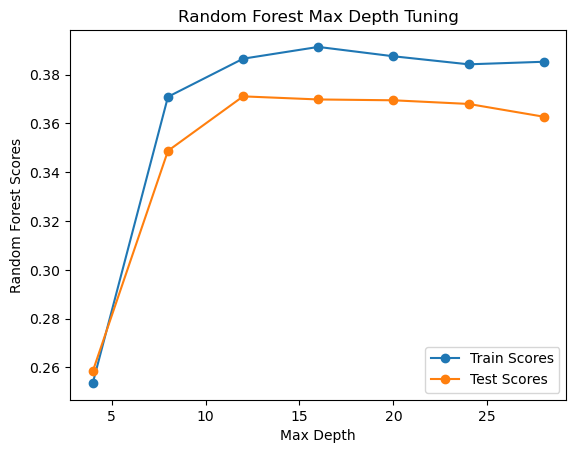

In [63]:
### TUNE MAX_DEPTH FOR COMMERCIAL ###

X_train, X_test, y_train, y_test = train_test_split(X_com_train, y_com_train, test_size=0.3)

depth_values = []
depth_train_scores = []
depth_test_scores = []

# Tune depth by comparing train and test scores
for depth in range(4,32,4):
    rf = RandomForestRegressor(n_estimators=40, max_depth=depth, max_features=None, max_leaf_nodes=20)
    rf.fit(X_train, y_train.ravel())
    train_score = rf.score(X_train, y_train)
    test_score = rf.score(X_test, y_test)
    depth_values.append(depth)
    depth_train_scores.append(train_score)
    depth_test_scores.append(test_score)

plt.plot(depth_values,depth_train_scores,marker='o',label='Train Scores')
plt.plot(depth_values,depth_test_scores,marker='o',label='Test Scores')
plt.legend()
plt.xlabel("Max Depth")
plt.ylabel("Random Forest Scores")
plt.title("Random Forest Max Depth Tuning (Commercial)")

Text(0.5, 1.0, 'Random Forest Max Leaf Nodes Tuning')

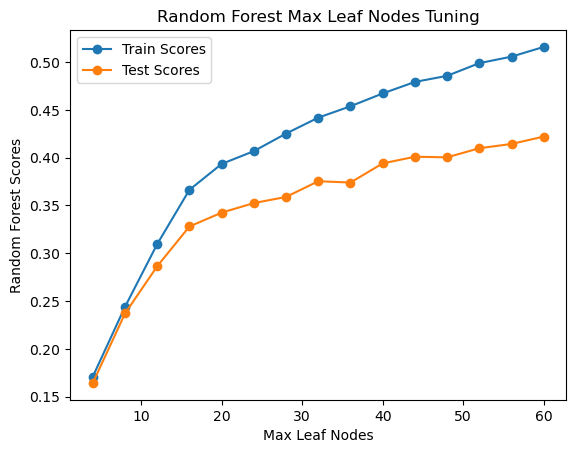

In [64]:
### TUNE MAX_LEAF_NODES FOR COMMERCIAL ###

X_train, X_test, y_train, y_test = train_test_split(X_com_train, y_com_train, test_size=0.3)

leaf_values = []
leaf_train_scores = []
leaf_test_scores = []

# Tune depth by comparing train and test scores
for leaf in range(4,64,4):
    rf = RandomForestRegressor(n_estimators=40, max_depth=12, max_features=None, max_leaf_nodes=leaf)
    rf.fit(X_train, y_train.ravel())
    train_score = rf.score(X_train, y_train)
    test_score = rf.score(X_test, y_test)
    leaf_values.append(leaf)
    leaf_train_scores.append(train_score)
    leaf_test_scores.append(test_score)

plt.plot(leaf_values,leaf_train_scores,marker='o',label='Train Scores')
plt.plot(leaf_values,leaf_test_scores,marker='o',label='Test Scores')
plt.legend()
plt.xlabel("Max Leaf Nodes")
plt.ylabel("Random Forest Scores")
plt.title("Random Forest Max Leaf Nodes Tuning (Commercial)")

Text(0.5, 1.0, 'Random Forest Max Depth Tuning (Residential)')

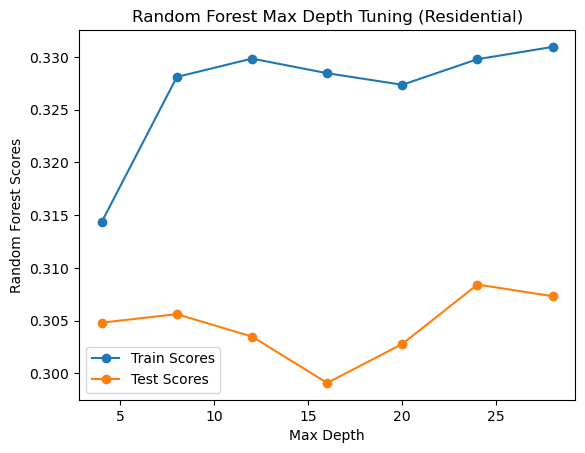

In [78]:
### TUNE MAX_DEPTH FOR RESIDENTIAL ###

X_train, X_test, y_train, y_test = train_test_split(X_res_train, y_res_train, test_size=0.3)

depth_values = []
depth_train_scores = []
depth_test_scores = []

# Tune depth by comparing train and test scores
for depth in range(4,32,4):
    rf = RandomForestRegressor(n_estimators=40, max_depth=depth, max_features=None, max_leaf_nodes=12)
    rf.fit(X_train, y_train.ravel())
    train_score = rf.score(X_train, y_train)
    test_score = rf.score(X_test, y_test)
    depth_values.append(depth)
    depth_train_scores.append(train_score)
    depth_test_scores.append(test_score)

plt.plot(depth_values,depth_train_scores,marker='o',label='Train Scores')
plt.plot(depth_values,depth_test_scores,marker='o',label='Test Scores')
plt.legend()
plt.xlabel("Max Depth")
plt.ylabel("Random Forest Scores")
plt.title("Random Forest Max Depth Tuning (Residential)")

Text(0.5, 1.0, 'Random Forest Max Leaf Nodes Tuning (Residential)')

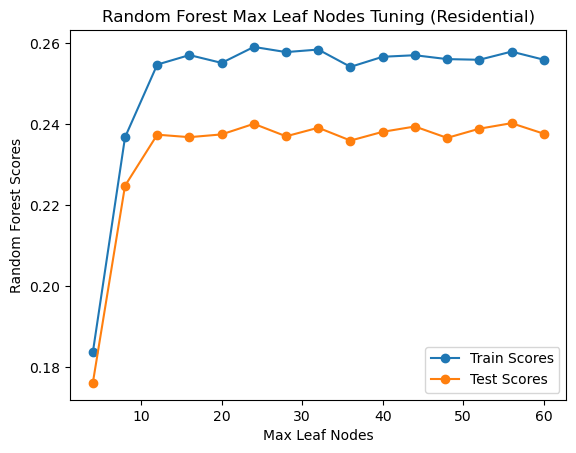

In [77]:
### TUNE MAX_LEAF_NODES FOR RESIDENTIAL ###

X_train, X_test, y_train, y_test = train_test_split(X_com_train, y_com_train, test_size=0.3)

leaf_values = []
leaf_train_scores = []
leaf_test_scores = []

# Tune depth by comparing train and test scores
for leaf in range(4,64,4):
    rf = RandomForestRegressor(n_estimators=40, max_depth=4, max_features=None, max_leaf_nodes=leaf)
    rf.fit(X_train, y_train.ravel())
    train_score = rf.score(X_train, y_train)
    test_score = rf.score(X_test, y_test)
    leaf_values.append(leaf)
    leaf_train_scores.append(train_score)
    leaf_test_scores.append(test_score)

plt.plot(leaf_values,leaf_train_scores,marker='o',label='Train Scores')
plt.plot(leaf_values,leaf_test_scores,marker='o',label='Test Scores')
plt.legend()
plt.xlabel("Max Leaf Nodes")
plt.ylabel("Random Forest Scores")
plt.title("Random Forest Max Leaf Nodes Tuning (Residential)")